In [17]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

1) Log file is loaded

In [18]:
file = open("log.txt", "r") 
lines = file.readlines()
for l in range(3): print(lines[l][:-1])

156.15.13.173 [01/Jan/2018:11:13:49 +0100] "GET AddProduct.html HTTP/1.0" 200 2356
176.247.135.49 [01/Jan/2018:11:18:07 +0100] "GET Shop.html HTTP/1.0" 200 7466
176.247.135.49 [01/Jan/2018:11:19:05 +0100] "GET AddProduct.html HTTP/1.0" 200 2356


2) Cass "Request" parses and keeps data of a single requests. Complete the TODO, where a given "line" (string) should be parsed in order to dervie the ip of the host making the request, time of the request (in seconds), and target page (name).

In [19]:
pattern_obj = re.compile(
    r'(?P<ip>([0-9]+\.){3}[0-9]+)\s\[[0-9]{2}/\w+/[0-9]{4}:(?P<hour>[0-9]{2}):(?P<minute>[0-9]{2}):(?P<second>[0-9]{2}).+\]\s\"\w+\s(?P<site>[a-zA-Z.]+)')


class Request:
    def __init__(self, line):
        # TODO DO PARSING HERE
        match_res = pattern_obj.match(line)
        if match_res:
            self.ip = match_res.group('ip')
            # convert hours + minutes + seconds -> total number of seconds
            hour = match_res.group('hour')
            minute = match_res.group('minute')
            second = match_res.group('second')
            self.time = int(second) + 60 * int(minute) + 3600 * int(hour)
            self.page = match_res.group('site')
        else:
            print('Error while parsing line. Match not found.')

    def __repr__(self):
        return self.ip + "     " + str(datetime.timedelta(seconds=self.time)) + " -> " + self.page


3) Each line of log.txt is parsed and the Request objects are added to the list

In [4]:
reqs = [Request(line) for line in lines]
for l in range(10): print(reqs[l]) 

156.15.13.173     11:13:49 -> AddProduct.html
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
57.116.45.120     11:46:45 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
26.19.183.202     11:53:11 -> AddProduct.html


# Exercise

Your task is to analyze the log file. You should indentify the users and sessions. Then, compute the following: <br>
3.1) the number of sessions (should be 1000 :) ), <br>
3.2) the number of users, <br>
3.3) the average number of sessions per one user <br>
3.4) use the distribution plot to visualize the sessions' lengths (minutes);  <br>
3.5) use the distribution plot to visualize the sessions' lengths (the number of requests) <br>
3.6) use the distribution plot to visualize sessions' starting times (hours). <br>
3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page,  <br>
3.8) which web page is the most common departure point?; for each page plot the number of times the user stopped a session while being on this page, <br>
3.9) for each page plot the average time the user stayed on this page <br>
3.10) print the fist 10 sessions (paths). <br>

You may find the following classes helpful and data.

In [20]:
class Session:
    def __init__(self, request):
        self.startTime = request.time
        self.stopTime = request.time
        self.requests = [request]

    def __repr__(self):
        print("SESSION")
        print(self.startTime)
        print(self.stopTime)
        STR = ""
        for r in self.requests:
            print(r)
            STR += ("  " + r.page + "    " + str(datetime.timedelta(seconds=r.time)) + "\n")
        return STR

    def add_request(self, request):
        self.requests.append(request)
        self.stopTime = request.time

    def get_delta_time_on_page(self, current_time):
        return current_time - self.stopTime

    def get_delta_time_session(self, current_time):
        return current_time - self.startTime

    def is_linked_to_or_same(self, query_page):
        query_page_index = PAGES.index(query_page)
        for req in self.requests:
            if query_page == req.page:
                return True
            req_page_index = PAGES.index(req.page)
            if query_page_index in LINKS[req_page_index]:
                return True
        return False


class Computer:
    def __init__(self, ip):
        self.ip = ip
        self.sessions = []

    def __repr__(self):
        return self.ip

    def add_req_to_last_session(self, request):
        self.sessions[-1].add_request(request)

    def create_new_session(self, first_request):
        self.sessions.append(Session(request=first_request))

    def last_sess_get_delta_time_on_page(self, current_time):
        if len(self.sessions) > 0:
            return self.sessions[-1].get_delta_time_on_page(current_time)
        else:
            return 0

    def last_sess_get_delta_time(self, current_time):
        if len(self.sessions) > 0:
            return self.sessions[-1].get_delta_time_session(current_time)
        else:
            return 0

    def last_sess_is_linked_to_or_same(self, page):
        if len(self.sessions) > 0:
            return self.sessions[-1].is_linked_to_or_same(page)
        else:
            return False


PAGES = ["Shop.html", "AddProduct.html", "Summary.html", "Payment.html", "About.html", "Contact.html"]

LINKS = [[1, 4],
         [2, 4],
         [3],
         [],
         [1, 5],
         []]

theta = 40 * 60  # Max session time in seconds
delta = 15 * 60  # Max time on a single page in seconds

computers = {}
global_sessions = []  # A list of all the sessions (because we need to know the first 10 sessions)

# Finding sessions
for req in reqs:
    comp = computers.get(req.ip)
    if not comp:
        comp = Computer(req.ip)
        computers[comp.ip] = comp
    if comp.last_sess_get_delta_time(req.time) > theta:
        comp.create_new_session(first_request=req)
        global_sessions.append(comp.sessions[-1])  # A list is passed as a reference so it will be up to date
    elif comp.last_sess_get_delta_time_on_page(req.time) > delta:
        comp.create_new_session(first_request=req)
        global_sessions.append(comp.sessions[-1])
    elif comp.last_sess_is_linked_to_or_same(req.page):
        comp.add_req_to_last_session(req)
    else:
        comp.create_new_session(first_request=req)
        global_sessions.append(comp.sessions[-1])

----Total number of sessions----
1000
----Total number of users----
391
----Average number of sessions per one user
2.558


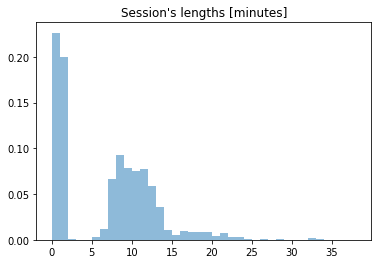

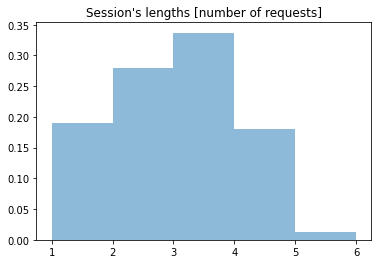

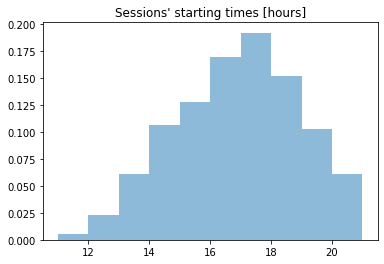

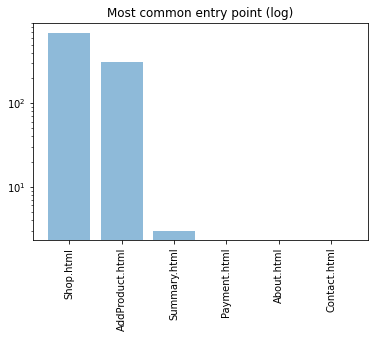

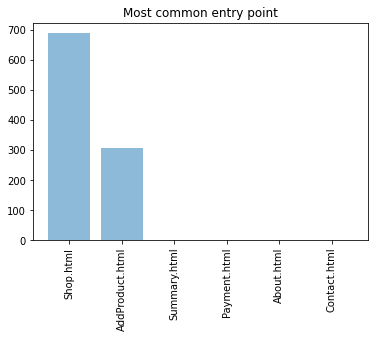

----The most common entry point----
Shop.html -> 689 times an entry point


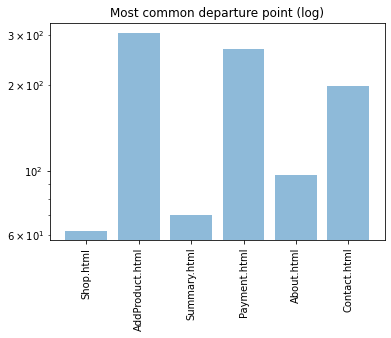

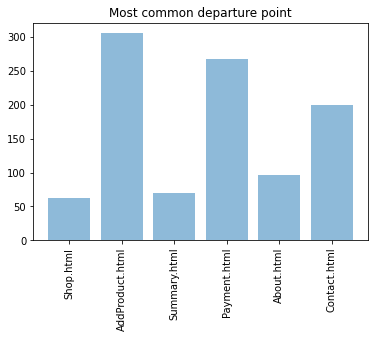

----The most common departure point----
AddProduct.html -> 305 times a departure point


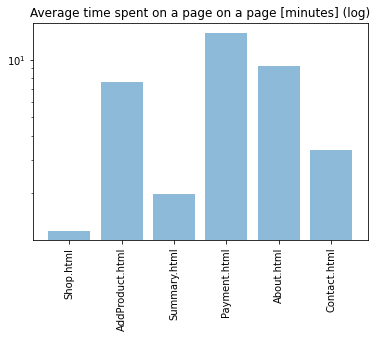

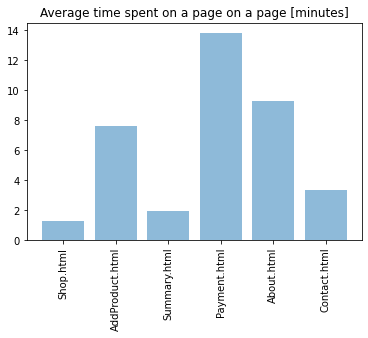

----First ten sessions----
SESSION
40429
40429
156.15.13.173     11:13:49 -> AddProduct.html
  AddProduct.html    11:13:49

SESSION
40687
41345
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
  Shop.html    11:18:07
  AddProduct.html    11:19:05
  Summary.html    11:29:05

SESSION
42239
42758
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
  Shop.html    11:43:59
  AddProduct.html    11:45:16
  Summary.html    11:50:36
  Payment.html    11:52:38

SESSION
42405
42927
57.116.45.120     11:46:45 -> AddProduct.html
57.116.45.120     11:53:25 -> Summary.html
57.116.45.120     11:55:27 -> Payment.html
  AddProduct.html    11:46:45
  Summary.html    11:53:25
  Payment.html    11:55:27

SESSION
42791
43610
26.19.183.202     11:53:11 -> AddProduct.html
26.19.183.202     11:59:00 -> About.html
2

In [24]:
# Sessions processing and display
sess_len_minutes = []
sess_req_num = []
sess_start_time_hours = []
entry_points = {}
departure_points = {}

for page in PAGES:
    entry_points[page] = 0
    departure_points[page] = 0


for sess in global_sessions:
    length = sess.stopTime - sess.startTime
    sess_len_minutes.append(length / 60)
    sess_req_num.append(len(sess.requests))
    sess_start_time_hours.append(int(sess.startTime / 3600))
    entry_points[sess.requests[0].page] += 1
    departure_points[sess.requests[-1].page] += 1

# 3.1) the number of sessions (should be 1000 :) )
print('----Total number of sessions----')
print(len(global_sessions))

# 3.2) the number of users
print('----Total number of users----')
print(len(computers))

# 3.3) the average number of sessions per one user
print('----Average number of sessions per one user')
print(round(len(global_sessions) / len(computers), 3))


#  3.4) use the distribution plot to visualize the sessions' lengths (minutes);
sess_len_minutes_array = np.array(sess_len_minutes)
bins = np.arange(np.floor(sess_len_minutes_array.min()),np.ceil(sess_len_minutes_array.max()))
plt.hist(sess_len_minutes_array, bins, alpha=0.5, density=True)
plt.title('Session\'s lengths [minutes]')
plt.show()

# 3.5) use the distribution plot to visualize the sessions' lengths (the number of requests)
sess_req_num_array = np.array(sess_req_num)
bins = np.arange(np.floor(sess_req_num_array.min()),np.ceil(sess_req_num_array.max()))
plt.hist(sess_req_num_array, bins, alpha=0.5, density=True)
plt.title('Session\'s lengths [number of requests]')
plt.show()

# 3.6) use the distribution plot to visualize sessions' starting times (hours)
sess_start_time_hours_array = np.array(sess_start_time_hours)
bins = np.arange(np.floor(sess_start_time_hours_array.min()),np.ceil(sess_start_time_hours_array.max()))
plt.hist(sess_start_time_hours_array, bins, alpha=0.5, density=True)
plt.title('Sessions\' starting times [hours]')
plt.show()


# 3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page
plt.bar(np.arange(len(entry_points.values())), entry_points.values(), log=True, align='center', alpha=0.5)
plt.xticks(np.arange(len(entry_points.keys())), labels=entry_points.keys(), rotation='vertical')
plt.title('Most common entry point (log)')
plt.show()
plt.bar(np.arange(len(entry_points.values())), entry_points.values(), align='center', alpha=0.5)
plt.xticks(np.arange(len(entry_points.keys())), labels=entry_points.keys(), rotation='vertical')
plt.title('Most common entry point')
plt.show()
print('----The most common entry point----')
most_common_no = 0
most_common = ''
for k, v in entry_points.items():
    if v > most_common_no:
        most_common_no = v
        most_common = k
print('{} -> {} times an entry point'.format(most_common, most_common_no))

# 3.8) which web page is the most common departure point?;
# for each page plot the number of times the user stopped a session while being on this page
plt.bar(np.arange(len(departure_points.values())), departure_points.values(), log=True, align='center', alpha=0.5)
plt.xticks(np.arange(len(departure_points.keys())), labels=departure_points.keys(), rotation='vertical')
plt.title('Most common departure point (log)')
plt.show()
plt.bar(np.arange(len(departure_points.values())), departure_points.values(), align='center', alpha=0.5)
plt.xticks(np.arange(len(departure_points.keys())), labels=departure_points.keys(), rotation='vertical')
plt.title('Most common departure point')
plt.show()
print('----The most common departure point----')
most_common_no = 0
most_common = ''
for k, v in departure_points.items():
    if v > most_common_no:
        most_common_no = v
        most_common = k
print('{} -> {} times a departure point'.format(most_common, most_common_no))

# 3.9) for each page plot the average time the user stayed on this page
time_on_page = {}
visits = {}
for page in PAGES:
    time_on_page[page] = 0
    visits[page] = 0


for session in global_sessions:
    for i, request in enumerate(session.requests):
        if i < len(session.requests) - 1: # We can't tell a time spent on the last page in session
            next_request = session.requests[i+1]
            time_on_page[request.page] += next_request.time - request.time
            visits[request.page] += 1
avg_time_on_page = {}
for page in PAGES:
    if visits[page] > 0:
        avg_time_on_page[page] = (time_on_page[page] / visits[page])/60
    else:
        avg_time_on_page[page] = 0
plt.bar(np.arange(len(avg_time_on_page.values())), avg_time_on_page.values(), log=True, align='center', alpha=0.5)
plt.xticks(np.arange(len(avg_time_on_page.keys())), labels=avg_time_on_page.keys(), rotation='vertical')
plt.title('Average time spent on a page on a page [minutes] (log)')
plt.show()
plt.bar(np.arange(len(avg_time_on_page.values())), avg_time_on_page.values(), align='center', alpha=0.5)
plt.xticks(np.arange(len(avg_time_on_page.keys())), labels=avg_time_on_page.keys(), rotation='vertical')
plt.title('Average time spent on a page on a page [minutes]')
plt.show()

# 3.10) print the first 10 sessions (paths).
print('----First ten sessions----')
for i in range(10):
    print(global_sessions[i])
